In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
import zipfile


import os
import glob
from pathlib import Path

import math
import re
import shutil

from collections import Counter
from itertools import cycle, islice

from PIL import Image
from sys import argv
from warnings import filterwarnings
filterwarnings("ignore")

C:\Users\MICHEAL\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Load JSON file to dictionary 

In [2]:
import json

with open("instances_attributes_train2020.json", "r") as json_file:
    train_labels = json.load(json_file)
    
len(train_labels)

6

In [3]:
#check dictionary size in bytes
import sys
size = sys.getsizeof(train_labels)
print(size)

360


In [4]:
#iterate through dictionary to identify keys
for keys, values in train_labels.items():
    print(keys, len(keys))
    #print(keys, values)

annotations 11
images 6
info 4
licenses 8
categories 10
attributes 10


#### Make a dictionary of image id's and their names so as to use this image id to map them to the image names when saving txt files for annotations 

In [5]:
image_name_dict = {}

#print(len(train_labels["images"]))
for names in train_labels["images"]:
    #print(names)
    #print(names["kaggle_id"], names["id"])
    image_name_dict[names["id"]] = names["kaggle_id"]

In [6]:
#we can confirm froim below that the length of the dictionary is the same a count of images
print(len(image_name_dict))

45623


### Extract annotations from the main dictionary to a list which contains dictionaries 

In [7]:
#print(len(list(train_labels["annotations"])))

anns = list(train_labels["annotations"])
print(len(anns))
print(anns[:2])
print(anns[0]["image_id"], anns[0]["bbox"])

333401
[{'image_id': 16305, 'category_id': 32, 'attribute_ids': [218], 'segmentation': [[471, 390, 461, 412, 457, 430, 454, 455, 454, 473, 457, 483, 469, 489, 477, 492, 485, 498, 493, 499, 499, 496, 500, 490, 494, 479, 487, 461, 485, 445, 483, 434, 487, 433, 489, 426, 489, 412, 484, 403, 480, 395, 477, 392]], 'bbox': [454.0, 390.0, 46.0, 109.0], 'area': 3052, 'iscrowd': 0, 'id': 0}, {'image_id': 16305, 'category_id': 31, 'attribute_ids': [204, 205, 159], 'segmentation': [[334, 329, 344, 307, 348, 293, 354, 282, 365, 273, 357, 265, 355, 261, 351, 252, 346, 246, 343, 243, 345, 236, 343, 225, 339, 212, 335, 197, 332, 191, 331, 189, 335, 185, 336, 183, 339, 184, 344, 184, 350, 181, 359, 177, 369, 172, 368, 165, 365, 154, 361, 148, 357, 145, 353, 144, 351, 140, 348, 136, 347, 133, 342, 135, 340, 137, 326, 139, 320, 140, 312, 142, 303, 144, 290, 145, 278, 148, 274, 151, 272, 154, 271, 184, 273, 211, 275, 223, 275, 235, 281, 246, 284, 256, 288, 266, 291, 280, 294, 287, 301, 311, 305, 324, 308

### Create new dict to save image_id as keys then save the bboxes as list of lists for each image that has more than one label

In [8]:

new_dict = {}
dataframe_list = []  #initialize list to save all image names, bbox and category to make a dataframe

for row in anns:
    #print(row.keys())
    image_id, bbox, cat = row["image_id"], row["bbox"], row["category_id"]
    #print(image_name, bbox, cat)
    dataframe_list.append([image_name_dict[image_id], bbox, cat])
    #insert category to first index in bbox list to save the category along with the annotations
    bbox.insert(0, cat)
    #check if the new dictionary is empty
    if not new_dict:
        new_dict[image_name_dict[image_id]] = [bbox]  #save the bbox into the new dictionary by mapping image id to image name
    else:
        #if image name already in dictionary keys, append new list  of bbox and category to the list
        if image_name_dict[image_id] in new_dict.keys():
            new_dict[image_name_dict[image_id]].append(bbox)
        else:
            new_dict[image_name_dict[image_id]] = [bbox]
    #print(bbox)

    
#save annotations to txt files in YOLO format
for filename, lists in new_dict.items():
    with open(f"annotations_yolo/{filename}" + '.txt', 'w') as f:
        for lst in lists:
            # Convert each item in the inner list to a string
            string_list = [str(item) for item in lst]
            f.write(' '.join(string_list) + '\n')
            

# Create the pandas DataFrame
df = pd.DataFrame(dataframe_list)

# Specify column names if necessary
df.columns = ['Image_name', 'bbox', 'category']
df

,Image_name,bbox,category
0,2f10b4d61e445fe5d0777723630a2905,"[32, 454.0, 390.0, 46.0, 109.0]",32
1,2f10b4d61e445fe5d0777723630a2905,"[31, 271.0, 133.0, 98.0, 223.0]",31
2,2f10b4d61e445fe5d0777723630a2905,"[31, 482.0, 323.0, 74.0, 169.0]",31
3,2f10b4d61e445fe5d0777723630a2905,"[22, 322.0, 658.0, 208.0, 112.0]",22
4,2f10b4d61e445fe5d0777723630a2905,"[22, 405.0, 749.0, 97.0, 213.0]",22
...,...,...,...
333396,5a70d25b564a0df8b71d6db8d61d1bfe,"[1, 149.0, 26.0, 515.0, 920.0]",1
333397,f51fb0808a58a13672f05cfc6b732459,"[21, 424.0, 603.0, 34.0, 65.0]",21
333398,f51fb0808a58a13672f05cfc6b732459,"[21, 488.0, 605.0, 36.0, 60.0]",21
333399,f51fb0808a58a13672f05cfc6b732459,"[23, 426.0, 662.0, 31.0, 19.0]",23


In [20]:
#add category names
cat_dict = {}

for row in list(train_labels["categories"]):
    #print(row["id"], row["name"].split(",")[0])
    cat_dict[row["id"]] = row["name"].split(",")[0]
    
# Create new column 'category_names' by mapping 'category' to 'category_dict'
df['category_names'] = df['category'].map(cat_dict)
df

,Image_name,bbox,category,category_names
0,2f10b4d61e445fe5d0777723630a2905,"[32, 454.0, 390.0, 46.0, 109.0]",32,pocket
1,2f10b4d61e445fe5d0777723630a2905,"[31, 271.0, 133.0, 98.0, 223.0]",31,sleeve
2,2f10b4d61e445fe5d0777723630a2905,"[31, 482.0, 323.0, 74.0, 169.0]",31,sleeve
3,2f10b4d61e445fe5d0777723630a2905,"[22, 322.0, 658.0, 208.0, 112.0]",22,sock
4,2f10b4d61e445fe5d0777723630a2905,"[22, 405.0, 749.0, 97.0, 213.0]",22,sock
...,...,...,...,...
333396,5a70d25b564a0df8b71d6db8d61d1bfe,"[1, 149.0, 26.0, 515.0, 920.0]",1,top
333397,f51fb0808a58a13672f05cfc6b732459,"[21, 424.0, 603.0, 34.0, 65.0]",21,tights
333398,f51fb0808a58a13672f05cfc6b732459,"[21, 488.0, 605.0, 36.0, 60.0]",21,tights
333399,f51fb0808a58a13672f05cfc6b732459,"[23, 426.0, 662.0, 31.0, 19.0]",23,shoe


In [21]:
def plot_col(df, col_name, types):
    """
    Function to plot chart based on column name
    Input parameters:- 
    df = dataframe
    col_name = column name
    types = type of plot (pie, box, bar)"""
    plt.figure(figsize=(12, 7))
    
    cmap = cm.get_cmap('RdYlGn')
    
    
    image =  df[col_name].value_counts().plot(kind=types, colormap = cmap)
    sn.distplot(df[col_name].value_counts())
    image.figure.savefig(f"{col_name}.jpg")
    
    return image

In [23]:
df.category_names.value_counts()

sleeve        59448
shoe          46374
neckline      34258
pocket        27179
dress         18739
top           16548
pants         12414
collar        10159
zipper         7991
jacket         7833
bag            7217
belt           6851
shirt          6161
lapel          5972
bead           5084
skirt          5046
rivet          4893
glasses        4855
tights         4326
applique       3529
headband       3470
watch          3389
buckle         3300
coat           3124
shorts         2756
sock           2582
hat            2518
ruffle         2407
sweater        1494
tie            1457
glove          1385
scarf          1374
flower         1367
hood           1226
cardigan       1107
sequin          929
jumpsuit        922
epaulette       874
vest            719
fringe          588
bow             528
tassel          335
ribbon          274
cape            152
umbrella        135
leg warmer      112
Name: category_names, dtype: int64

<AxesSubplot:xlabel='category_names', ylabel='Density'>

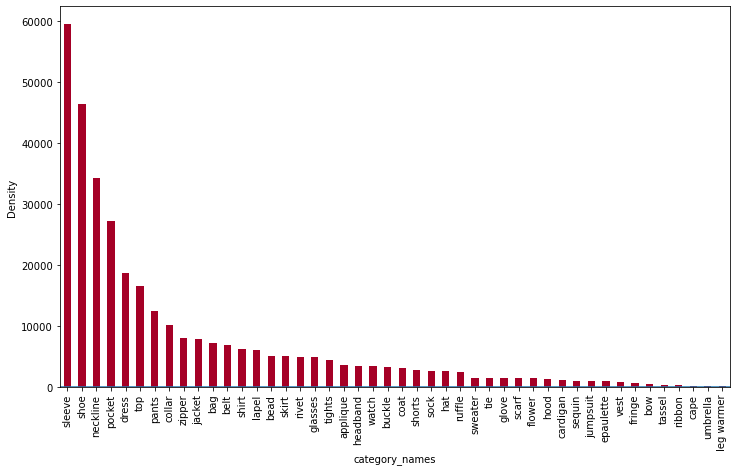

In [22]:
plot_col(df, "category_names", "bar")

0 shirt
1 top
2 sweater
3 cardigan
4 jacket
5 vest
6 pants
7 shorts
8 skirt
9 coat
10 dress
11 jumpsuit
12 cape
13 glasses
14 hat
15 headband
16 tie
17 glove
18 watch
19 belt
20 leg warmer
21 tights
22 sock
23 shoe
24 bag
25 scarf
26 umbrella
27 hood
28 collar
29 lapel
30 epaulette
31 sleeve
32 pocket
33 neckline
34 buckle
35 zipper
36 applique
37 bead
38 bow
39 flower
40 fringe
41 ribbon
42 rivet
43 ruffle
44 sequin
45 tassel
